Banco de dados com valores de alugueis de imóveis de 5 cidades brasileiras: São Paulo, Rio de Janeiro, Belo Horizonte, Porto Alegre e Campinas.

Fazer a predição dos valores através de modelos que utilizam regressão.

Fonte: https://www.kaggle.com/datasets/fabiobarreto/imoveis-aluguel

## **Importando os dados e fazendo breve análise**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

%matplotlib inline

In [ ]:
df = pd.read_csv("casas_aluguel.csv")

In [ ]:
df

**Verificando se há dados nulos**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


**Verificando se há dados duplicados**

In [ ]:
df.duplicated().sum()

358

Excluindo...

In [ ]:
df.drop_duplicates()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,Porto Alegre,63,2,1,1,5,not acept,furnished,402,1478,24,22,1926
10688,São Paulo,285,4,4,4,17,acept,not furnished,3100,15000,973,191,19260
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,980,6000,332,78,7390
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,1585,12000,279,155,14020


**Como visto na análise dos dataset, há dados preenchidos por "-" no lugar dos valores não preenchidos, vamos preencher por NaN para tratamento dentro do modelo.**

In [ ]:
df["floor"].replace("-", np.nan, inplace=True)

**Verificando...**

In [ ]:
df["floor"].value_counts()

##**Black box - XGBoost**

Motando nossa Pipeline:

In [ ]:
#Separando o que é features e target:
X = df.drop(columns="total (R$)")
y = df["total (R$)"]

# Dividindo em dados de teste e dados de treino, peguei 20% para dados de teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# ==========================================================
#Primeiro vamos tratar as features numéricas. Tratando os valores nulos (NaN) e escalonando já que a variância entre as features é grande.
pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                              ("std", StandardScaler())])

# Pegando só as features numéricas
features_num = X_train.select_dtypes(include=np.number).columns.tolist()

# ==========================================================
# Tratando as features categóricas. Os valores nulos (NaN) serão preenchidos por "unknown"  e posteriormente codificaremos todas elas com o Encoders
pipe_features_oh = Pipeline([("input_cat_oh", SimpleImputer(strategy="constant", fill_value="unknown")),
                             ("onehot", OneHotEncoder(handle_unknown = "ignore"))])

features_oh = ["animal", "furniture"]
# ==========================================================
pipe_features_oe = Pipeline([("input_cat_oe", SimpleImputer(strategy="constant", fill_value="unknown")),
                             ("ordinal", OrdinalEncoder())])

features_oe = ["city"]
# ==========================================================
# Pré-processador => Pegando as pipelines anteriores e unindo-as.
pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                     ("transf_cat_oh", pipe_features_oh, features_oh),
                                     ("transf_cat_oe", pipe_features_oe, features_oe)])

# ==========================================================
# Pipeline final, usando o pré-processador e o estimador que queremos utilizar, neste caso o XGBoost para regressão.
pipe_xgbr = Pipeline([("pre_processador", pre_processador),
                     ("xgbr", XGBRegressor(eval_metric='logloss', random_state=42))])


# ==========================================================
#Vamos dividir em splits para ter maior variedade de resultados.
splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#Montando a grade de parâmetros do estimador (XGBoost)
params_grid_xgbr = {"xgbr__n_estimators": [500, 1000, 5000],
                   "xgbr__max_depth": [2, 3],
                   "xgbr__learning_rate": [0.001, 0.01],
                   "xgbr__colsample_bytree": [0.5],
                   "xgbr__subsample": [0.5],
                   "xgbr__booster": ["gbtree"],
                   "xgbr__reg_alpha": [0.9]} 

#Motando a grade geral de parâmetros.
aluguelDeCasas_01_xgbr = GridSearchCV(estimator=pipe_xgbr,
                       param_grid=params_grid_xgbr,
                       scoring="r2",
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

aluguelDeCasas_01_xgbr.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


[15:16:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_processador',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['area',
                                                                          'rooms',
                                                                          'bathroom',
                                                                          'parking '
                       

In [ ]:
# Predições de treino
y_pred_train = aluguelDeCasas_01_xgbr.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

# Predições de teste
y_pred_test = aluguelDeCasas_01_xgbr.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}") 


Métricas de treino:

R^2: 0.98
MAE: 521.00
RMSE: 2625.13

Métricas de teste:

R^2: 0.95
MAE: 521.54
RMSE: 1463.21


In [ ]:
aluguelDeCasas_01_xgbr.best_params_

{'xgbr__booster': 'gbtree',
 'xgbr__colsample_bytree': 0.5,
 'xgbr__learning_rate': 0.01,
 'xgbr__max_depth': 2,
 'xgbr__n_estimators': 1000,
 'xgbr__reg_alpha': 0.9,
 'xgbr__subsample': 0.5}

In [ ]:
xgbr_results = pd.DataFrame(aluguelDeCasas_01_xgbr.cv_results_)
xgbr_results.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbr__booster,param_xgbr__colsample_bytree,param_xgbr__learning_rate,param_xgbr__max_depth,param_xgbr__n_estimators,param_xgbr__reg_alpha,param_xgbr__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.693615,0.563168,0.047238,0.005185,gbtree,0.5,0.01,2,1000,0.9,0.5,"{'xgbr__booster': 'gbtree', 'xgbr__colsample_b...",0.47811,0.879811,0.875552,0.942794,0.889313,0.813116,0.169232,1


**Salvando o estimador...**

In [ ]:
import pickle

In [ ]:
with open("aluguelDeCasas_01_xgbr.pkl", "wb") as f:
    pickle.dump(aluguelDeCasas_01_xgbr, f)

In [ ]:
with open("aluguelDeCasas_01_xgbr.pkl", "rb") as f:
    
    aluguelDeCasas_01_xgbr = pickle.load(f)

[19:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


**Vamos agora fazer uma breve comparação entre os dados originais e os preditos.**

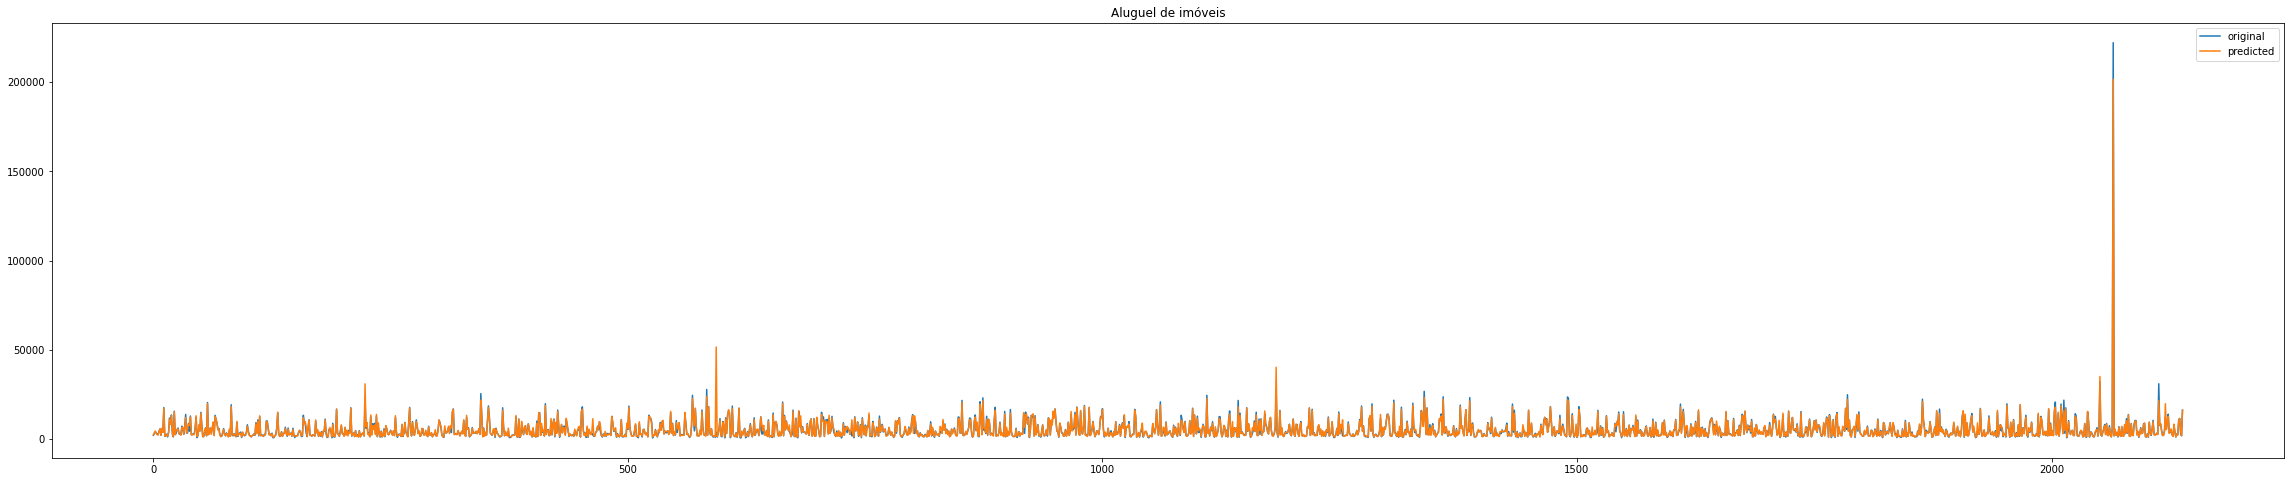

In [ ]:
plt.figure(figsize=(40,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Valores originais")
plt.plot(x_ax, y_pred_test, label="Valores preditos")
plt.title("Aluguel de imóveis")
plt.legend()
plt.show();

**Vamos criar uma tabela com a porcentagem de acertos para cada dado**

In [ ]:
tabela = pd.DataFrame()

In [ ]:
tabela["valores reais"] = y_test

In [ ]:
tabela["valores preditos"] = y_pred_test

In [ ]:
tabela["porcentagem de acerto %"]= (y_test/y_pred_test)*100

In [ ]:
lista_num = []
for c in tabela["porcentagem de acerto %"]:
  if c > 100:
    num = abs(c - 200)
    lista_num.append(num)
  else:
    num = c
    lista_num.append(num)
  

tabela["porcentagem de acerto %"]= lista_num

In [ ]:
tabela

,valores reais,valores preditos,porcentagem de acerto %
3165,2134,2473.410645,86.277627
9265,3345,3462.752686,96.599449
1940,4226,4515.419922,93.590410
10439,3474,3126.400146,88.881786
395,2760,2511.424805,90.102224
...,...,...,...
5633,10670,10128.360352,94.652247
3951,11550,11585.111328,99.696927
3970,3279,4818.633301,68.048341
2571,1929,1859.332031,96.253065


In [ ]:
tabela.to_csv("01-aluguelDeCasas_resultado.csv")

##**Interpretando o modelo globalmente**

**Para a interpretação só podemos considerar as features numéricas, vamos retirar as features categóricas:**

Percebemos que as features que tem dados como números contínuos tem um maior impacto na interpretação do que as features com dados como números discretos e as features com os maiores valores pesam mais na saída final, se analisarmos no dataset veremos que os valores da feature 'rent amount' são maiores que 'hoa' e assim sucessivamente como vemos no gráfico final:

**SHAP**

In [ ]:
!pip install shap
import shap

In [ ]:
df = pd.read_csv("casas_aluguel.csv")
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


**Agora vamos tratar o NaN dentro da coluna "floor":**

In [ ]:
df["floor"].replace("-", np.nan, inplace=True)

In [ ]:
ss = SimpleImputer(missing_values=np.nan, strategy="median")
ss.fit(df[["floor"]])

m = ss.transform(df[["floor"]])
df[["floor"]] = m

**O Shap só aceita dados numéricos, vamos transformar as Features categóricas em numéricas.**

**Transformando as Features categóricas em numéricas - OneHotEnconder - Features de dados binários:**

In [ ]:
#"animal", "furniture"
ohe =  OneHotEncoder(handle_unknown='ignore')
ohe.fit(df[["furniture"]])


df["furniture"] = ohe.transform(df[["furniture"]]).toarray()

**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [ ]:
# "city"
oe =  OrdinalEncoder()
oe.fit(df[["city"]])


df["city"] = oe.transform(df[["city"]])

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [ ]:
ssc = StandardScaler()

ssc.fit(df[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']])
h= ssc.transform(df[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']])
df[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']] = h

In [ ]:
df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,0.752567,-0.147522,-0.432099,-0.878960,-0.383245,0.143590,0.534522,1.761488,0.057145,-0.174935,-0.050103,-0.236589,5618
1,0.752567,0.318035,1.275535,1.253036,-1.012395,2.533254,0.534522,-0.567702,0.001666,0.312099,0.445121,0.203056,7973
2,-0.649497,-0.128899,-1.285916,-0.878960,-0.383245,-0.040230,0.534522,-0.567702,-0.011161,-0.321632,-0.117999,-0.257525,3841
3,-0.649497,-0.182904,-0.432099,-0.878960,-1.012395,-0.775511,0.534522,-0.567702,-0.057981,-0.816881,-0.110920,-0.759976,1421
4,0.752567,-0.231322,-1.285916,-0.878960,-1.012395,-0.959332,-1.870829,-0.567702,-0.075298,-0.908420,-0.109955,-0.885589,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,-0.649497,-0.160557,-0.432099,-0.878960,-0.383245,-0.224050,-1.870829,1.761488,-0.049515,-0.709499,-0.110276,-0.655299,1926
10688,0.752567,0.252857,1.275535,1.253036,1.504205,1.981793,0.534522,-0.567702,0.123527,3.257774,0.195095,2.882798,19260
10689,0.051535,-0.147522,0.421718,0.542371,-1.012395,0.327411,-1.870829,1.761488,-0.012444,0.617228,-0.011167,0.517088,7390
10690,0.051535,-0.054410,-0.432099,-0.168294,0.245905,0.327411,0.534522,1.761488,0.026359,2.377592,-0.028222,2.129120,14020


**Separar em features e target...**

In [ ]:
X = df[["hoa (R$)", "rent amount (R$)", "parking spaces", "bathroom", "property tax (R$)", "fire insurance (R$)", "rooms", "area"]]
y = df["total (R$)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [ ]:
xgbr = XGBRegressor().fit(X_train, y_train)

[15:27:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
explainer = shap.TreeExplainer(xgbr)

In [ ]:
shap_vals = explainer.shap_values(X_train)

**Temos abaixo as Features que mais impactaram na escolha dos valores preditivos para todos os dados:**

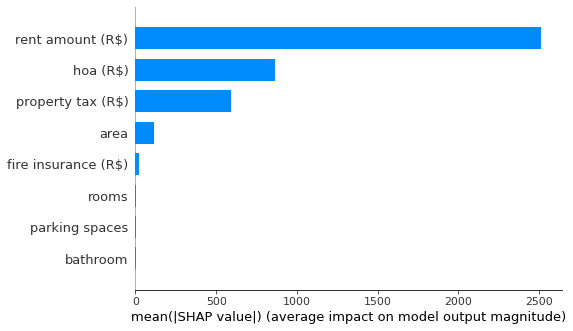

In [ ]:
shap.summary_plot(shap_vals, X_train, plot_type="bar")